# SC4001 Deep Learning - Group Project
## Oxford Flowers 102 Recognition

### Role: Person C - Advanced Techniques & Analysis

This notebook contains:
1. Few-Shot Learning experiments (1, 5, 10 samples per class)
2. Advanced Techniques (MixUp, Triplet Loss)
3. Performance comparison and reporting

## Part 1: Imports and Setup

In [37]:
import os
import json
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset

from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from baseline_model import (
	set_seed,
	get_flowers_dataloaders,
	train_epoch,
	validate,
	create_model_with_timeout
)


In [38]:
try:
    from baseline_model import (
        set_seed,
        get_data_transforms,
        create_baseline_model,
        train_epoch,
        validate,
        create_model_with_timeout,
        get_flowers_dataloaders 
    )
    print("Successfully imported from baseline_model.py")
except ImportError:
    print("ERROR: Could not import from baseline_model.py")
    print("Please ensure 'baseline_model.py' is in the same folder as this notebook.")

print("\nPerson C - Advanced Techniques Module Loaded")

device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)
set_seed(42)
print(f"Using device: {device}")


data_root = '../data'

Seed set to 42


Successfully imported from baseline_model.py

Person C - Advanced Techniques Module Loaded
Using device: mps


## Part 2: Few-Shot Learning

Code for creating k-shot datasets and training the models.

In [39]:
class FewShotDataset:
    """Create few-shot subsets of the training data"""
    
    def __init__(self, full_dataset, k_shot, num_classes=102, seed=42):
        """
        Args:
            full_dataset: Original training dataset (MUST be loaded with transform=None)
            k_shot: Number of samples per class (1, 5, or 10)
            num_classes: Total number of classes
            seed: Random seed for reproducibility
        """
        self.full_dataset = full_dataset
        self.k_shot = k_shot
        self.num_classes = num_classes
        
        random.seed(seed)
        np.random.seed(seed)
        
        # Group indices by class
        class_indices = defaultdict(list)
        
        # Use _labels attribute from Flowers102 dataset for efficiency
        try:
            labels = self.full_dataset._labels
            for idx, label in enumerate(labels):
                class_indices[label].append(idx)
        except AttributeError:
            print("Warning: Could not use ._labels, iterating dataset slowly...")
            for idx in range(len(full_dataset)):
                _, label = full_dataset[idx]
                class_indices[label].append(idx)
        
        # Sample k images per class
        self.selected_indices = []
        for class_id in range(num_classes):
            if len(class_indices[class_id]) >= k_shot:
                sampled = random.sample(class_indices[class_id], k_shot)
                self.selected_indices.extend(sampled)
            else:
                # Safeguard if a class has < k_shot samples (shouldn't happen for 1, 5, 10)
                print(f"Warning: Class {class_id} has fewer than {k_shot} samples. Using all.")
                self.selected_indices.extend(class_indices[class_id])
        
        print(f"\nFew-Shot Dataset Created:")
        print(f"  K-shot: {k_shot}")
        print(f"  Total samples: {len(self.selected_indices)}")
        print(f"  Expected: {num_classes * k_shot}")
    
    def get_subset(self, target_dataset):
        """Return PyTorch Subset *from the target_dataset* using selected indices"""
        return Subset(target_dataset, self.selected_indices)

In [40]:
def create_fewshot_dataloaders(k_shot, batch_size=32, num_workers=4):
    """
    Create dataloaders for few-shot learning
    """
    train_transform, test_transform = get_data_transforms()
    
    # Load a raw version of the training set (transform=None) 
    # This is only for sampling indices based on labels.
    train_dataset_raw = datasets.Flowers102(
        root=data_root,
        split='train',
        download=True,
        transform=None
    )
    
    # Load the transformed version of the training set.
    # This is the dataset we will actually train on.
    train_dataset_full = datasets.Flowers102(
        root=data_root,
        split='train',
        download=False, # Already downloaded
        transform=train_transform
    )
    
    # Create few-shot sampler using the RAW dataset to get indices
    fewshot_sampler = FewShotDataset(train_dataset_raw, k_shot=k_shot)
    # Create the final Subset using the TRANSFORMED dataset
    train_subset = fewshot_sampler.get_subset(train_dataset_full)
    
    # Validation and test remain the same
    val_dataset = datasets.Flowers102(
        root=data_root,
        split='val',
        download=True,
        transform=test_transform
    )
    
    test_dataset = datasets.Flowers102(
        root=data_root,
        split='test',
        download=True,
        transform=test_transform
    )
    
    pin_mem = True if torch.cuda.is_available() else False
    num_workers = 2 if os.name == 'nt' else num_workers 
    
    # Create dataloaders
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_mem
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_mem
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_mem
    )
    
    return train_loader, val_loader, test_loader

In [41]:
def train_fewshot_model(k_shot, model_name='resnet18', num_epochs=50, lr=0.001):
    """
    Train model with few-shot learning
    """
    print(f"\n{'='*60}")
    print(f"Training {k_shot}-Shot Learning Model (Arch: {model_name})")
    print(f"{'='*60}")
    
    # Create few-shot dataloaders
    train_loader, val_loader, test_loader = create_fewshot_dataloaders(
        k_shot=k_shot,
        batch_size=32
    )
    
    # Create model
    if 'vit' in model_name:
        model = create_model_with_timeout(model_name, num_classes=102, device=device)
    else:
        model = create_baseline_model(num_classes=102, pretrained=True, model_name=model_name)
        model = model.to(device)
    
    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    
    # Training loop
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Scheduler step
        scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"  ✓ New best! Val Acc: {val_acc:.2f}%")
        
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
        print(f"  Val: Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
    
    # Load best model and evaluate on test
    model.load_state_dict(best_model_state)
    test_loss, test_acc = validate(model, test_loader, criterion, device, valid_or_test="test")
    
    history['best_val_acc'] = best_val_acc
    history['test_loss'] = test_loss
    history['test_acc'] = test_acc
    history['k_shot'] = k_shot
    
    print(f"\n{'='*60}")
    print(f"{k_shot}-Shot Results ({model_name}):")
    print(f"  Best Val Acc: {best_val_acc:.2f}%")
    print(f"  Test Acc: {test_acc:.2f}%")
    print(f"{'='*60}")
    
    return model, history

## Part 3: MixUp Augmentation

In [42]:
def mixup_data(x, y, alpha=1.0, device='cuda'):
    """
    Apply MixUp augmentation
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """MixUp loss function"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train_epoch_mixup(model, dataloader, criterion, optimizer, device, alpha=1.0):
    """Training epoch with MixUp augmentation"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training (MixUp)')
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)
        
        # Apply MixUp
        mixed_images, labels_a, labels_b, lam = mixup_data(images, labels, alpha, device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(mixed_images)
        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (lam * predicted.eq(labels_a).sum().item() + 
                    (1 - lam) * predicted.eq(labels_b).sum().item())
        
        pbar.set_postfix({
            'loss': running_loss/(batch_idx+1),
            'acc': 100.*correct/total
        })
    
    return running_loss/len(dataloader), 100.*correct/total

In [43]:
def train_with_mixup(model_name='resnet18', num_epochs=30, alpha=1.0, lr=0.001):
    """
    Train model with MixUp augmentation
    """
    print(f"\n{'='*60}")
    print(f"Training with MixUp (alpha={alpha}, Arch: {model_name})")
    print(f"{'='*60}")
    
    # Import baseline dataloader (this uses the 10-shot train set)
    train_loader, val_loader, test_loader = get_flowers_dataloaders(
        batch_size=32
    )
    
    # Create model
    if 'vit' in model_name:
        model = create_model_with_timeout(model_name, num_classes=102, device=device)
    else:
        model = create_baseline_model(num_classes=102, pretrained=True, model_name=model_name)
        model = model.to(device)
    
    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    # Training loop
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train with MixUp
        train_loss, train_acc = train_epoch_mixup(
            model, train_loader, criterion, optimizer, device, alpha=alpha
        )
        
        # Validate (no MixUp)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Scheduler step
        scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"  ✓ New best! Val Acc: {val_acc:.2f}%")
        
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
        print(f"  Val: Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
    
    # Evaluate on test set
    model.load_state_dict(best_model_state)
    test_loss, test_acc = validate(model, test_loader, criterion, device, valid_or_test="test")
    
    history['best_val_acc'] = best_val_acc
    history['test_loss'] = test_loss
    history['test_acc'] = test_acc
    history['alpha'] = alpha
    
    print(f"\n{'='*60}")
    print(f"MixUp Results (alpha={alpha}, {model_name}):")
    print(f"  Best Val Acc: {best_val_acc:.2f}%")
    print(f"  Test Acc: {test_acc:.2f}%")
    print(f"{'='*60}")
    
    return model, history

## Part 4: Triplet Loss

In [44]:
class TripletLoss(nn.Module):
    """Triplet Loss for metric learning"""
    
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive, 2)
        distance_negative = F.pairwise_distance(anchor, negative, 2)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()


class TripletDataset(Dataset):
    """Dataset that returns triplets (anchor, positive, negative)"""
    
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        
        # Group indices by class
        self.class_indices = defaultdict(list)
        try:
            labels = self.base_dataset._labels
            for idx, label in enumerate(labels):
                self.class_indices[label].append(idx)
                
        except AttributeError:
            print("Warning: Iterating slowly for TripletDataset...")
            for idx in range(len(base_dataset)):
                _, label = base_dataset[idx]
                self.class_indices[label].append(idx)
           
        self.classes = list(self.class_indices.keys())

    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        # Get anchor
        anchor_img, anchor_label = self.base_dataset[idx]
        
        # Get positive (same class)
        positive_indices = self.class_indices[anchor_label]
        positive_idx = idx
        if len(positive_indices) > 1:
            while positive_idx == idx: 
                positive_idx = random.choice(positive_indices)
        else:
            positive_idx = idx 
            
        positive_img, _ = self.base_dataset[positive_idx]
        
        # Get negative (different class)
        negative_label = anchor_label
        while negative_label == anchor_label:
            negative_label = random.choice(self.classes)
            
        negative_idx = random.choice(self.class_indices[negative_label])
        negative_img, _ = self.base_dataset[negative_idx]
        
        return anchor_img, positive_img, negative_img, anchor_label                

In [45]:
class TripletModelWrapper(nn.Module):
    """Wraps a base model for triplet loss AND classification"""
    
    def __init__(self, base_model, embedding_dim=128, num_classes=102):
        super(TripletModelWrapper, self).__init__()
        
        # Get feature dimension from the base_model's fc layer
        try:
            num_features = base_model.fc.in_features
            base_model.fc = nn.Linear(num_features, embedding_dim)
        except AttributeError:
            num_features = base_model.head.in_features
            base_model.head = nn.Linear(num_features, embedding_dim)
            
        self.base_model = base_model
        
        # Add a new classification head after the embedding layer
        self.classifier = nn.Linear(embedding_dim, num_classes)
    
    def forward(self, x, return_embedding=False):
        # Get the embedding from the modified base model
        embedding = self.base_model(x)
        
        if return_embedding:
            return embedding
        
        # Pass the embedding to the new classifier
        logits = self.classifier(embedding)
        return logits, embedding

In [46]:
def train_epoch_triplet(model, dataloader, criterion_triplet, criterion_cls, 
                        optimizer, device, lambda_triplet=0.5):
    """Training epoch with combined triplet and classification loss"""
    model.train()
    running_loss = 0.0
    running_triplet_loss = 0.0
    running_cls_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training (Triplet)')
    
    for batch_idx, (anchor, positive, negative, labels) in enumerate(pbar):
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Get outputs for all three images
        anchor_out, anchor_emb = model(anchor)
        positive_out, positive_emb = model(positive)
        negative_out, negative_emb = model(negative)
        
        # Compute Triplet loss
        triplet_loss = criterion_triplet(anchor_emb, positive_emb, negative_emb)
        
        # Compute Classification loss (on the anchor)
        cls_loss = criterion_cls(anchor_out, labels)
        
        # Combined loss
        loss = lambda_triplet * triplet_loss + (1 - lambda_triplet) * cls_loss
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        running_triplet_loss += triplet_loss.item()
        running_cls_loss += cls_loss.item()
        
        _, predicted = anchor_out.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': running_loss/(batch_idx+1),
            'triplet': running_triplet_loss/(batch_idx+1),
            'cls': running_cls_loss/(batch_idx+1),
            'acc': 100.*correct/total
        })
    
    return running_loss/len(dataloader), 100.*correct/total

In [47]:
def train_with_triplet_loss(model_name='resnet18', num_epochs=30, margin=1.0, 
                            lambda_triplet=0.5, lr=0.001):
    """
    Train model with triplet loss
    """
    
    # ==================================================================
    # NESTED HELPER FUNCTION TO FIX THE KERNEL ERROR
    # ==================================================================
    def validate_triplet_model(model, dataloader, criterion, device, valid_or_test="Validation"):
        """
        Special validation function for the TripletModelWrapper
        that unpacks the (logits, embedding) tuple.
        """
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(dataloader, desc=valid_or_test)
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(pbar):
                images, labels = images.to(device), labels.to(device)
                
                # --- THIS IS THE FIX ---
                outputs, _ = model(images) 
                # --- END OF FIX ---
                
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                pbar.set_postfix({
                    'loss': running_loss/(batch_idx+1),
                    'acc': 100.*correct/total
                })
        return running_loss/len(dataloader), 100.*correct/total
    # ==================================================================
    # END OF NESTED FUNCTION
    # ==================================================================

    print(f"\n{'='*60}")
    print(f"Training with Triplet Loss (margin={margin}, lambda={lambda_triplet}, Arch={model_name})")
    print(f"{'='*60}")
    
    # Load datasets
    train_transform, test_transform = get_data_transforms()
    
    train_dataset = datasets.Flowers102(
        root= data_root, split='train', transform=train_transform
    )
    val_dataset = datasets.Flowers102(
        root=data_root, split='val', transform=test_transform
    )
    test_dataset = datasets.Flowers102(
        root=data_root, split='test', transform=test_transform
    )
    
    # Create triplet dataset for training
    triplet_train_dataset = TripletDataset(train_dataset)
    
    # --- THIS FIX IS ALSO CRITICAL ---
    # The num_workers MUST be 0 for custom classes in Jupyter
    train_loader = DataLoader(triplet_train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    # --- END OF CRITICAL FIX ---
    
    # Create base model
    if 'vit' in model_name:
        base_model = create_model_with_timeout(model_name, num_classes=102, device=device, pretrained=True)
    else:
        base_model = create_baseline_model(num_classes=102, pretrained=True, model_name=model_name)
    
    # Wrap in triplet model
    model = TripletModelWrapper(base_model, embedding_dim=128, num_classes=102)
    model = model.to(device)
    
    # Training setup
    criterion_triplet = TripletLoss(margin=margin)
    criterion_cls = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    history = {
        'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
    }
    
    best_val_acc = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_epoch_triplet(
            model, train_loader, criterion_triplet, criterion_cls,
            optimizer, device, lambda_triplet=lambda_triplet
        )
        
        # --- THIS WILL NOW CALL THE NESTED FUNCTION ---
        val_loss, val_acc = validate_triplet_model(model, val_loader, criterion_cls, device)
        
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"  ✓ New best! Val Acc: {val_acc:.2f}%")
        
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
        print(f"  Val: Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
    
    # --- THIS WILL ALSO CALL THE NESTED FUNCTION ---
    model.load_state_dict(best_model_state)
    test_loss, test_acc = validate_triplet_model(model, test_loader, criterion_cls, device, valid_or_test="test")
    
    history['best_val_acc'] = best_val_acc
    history['test_loss'] = test_loss
    history['test_acc'] = test_acc
    history['margin'] = margin
    history['lambda_triplet'] = lambda_triplet
    
    print(f"\n{'='*60}")
    print(f"Triplet Loss Results ({model_name}):")
    print(f"  Best Val Acc: {best_val_acc:.2f}%")
    print(f"  Test Acc: {test_acc:.2f}%")
    print(f"{'='*60}")
    
    return model, history

## Part 5: Experiment Runner

This master function runs all experiments for Person C.

In [48]:
def run_all_experiments(quick_test=False):
    """
    Run all Person C experiments
    
    Args:
        quick_test: If True, run with reduced epochs for testing
    
    Returns:
        results: Dictionary containing all experiment results
    """
    results = {}
    
    # Set epochs based on mode
    epochs_fewshot = 50 if not quick_test else 3 # 50 epochs for few-shot
    epochs_standard = 30 if not quick_test else 3 # 30 epochs for others
    
    print("\n" + "="*80)
    print("PERSON C - ADVANCED TECHNIQUES EXPERIMENTS")
    print(f"QUICK TEST MODE: {quick_test}")
    print("="*80)
    
    # Define base model for comparison
    # We use resnet18 to compare against Person A's baseline
    # We can also run this with 'vit_base_patch32_224' to compare against Person B
    BASE_MODEL_NAME = 'resnet18'
    
    # ===== EXPERIMENT 1: Few-Shot Learning =====
    print("\n\n### EXPERIMENT 1: Few-Shot Learning ###\n")
    
    fewshot_results = {}
    for k_shot in [1, 5, 10]:
        try:
            model, history = train_fewshot_model(
                k_shot=k_shot,
                model_name=BASE_MODEL_NAME,
                num_epochs=epochs_fewshot,
                lr=0.001
            )
            fewshot_results[f'{k_shot}_shot'] = history
            
            # Save model
            save_dir = f'results/person_c/fewshot_{k_shot}shot_{BASE_MODEL_NAME}'
            os.makedirs(save_dir, exist_ok=True)
            torch.save(model.state_dict(), f'{save_dir}/model.pth')
            
        except Exception as e:
            print(f"ERROR in {k_shot}-shot learning: {e}")
            if "baseline_model" in str(e):
                print("*** HINT: 'baseline_model.py' not found. Stopping. ***")
                break 
    
    results['fewshot'] = fewshot_results
    
    # ===== EXPERIMENT 2: MixUp Augmentation =====
    print("\n\n### EXPERIMENT 2: MixUp Augmentation ###\n")
    
    mixup_results = {}
    # Run only on alpha=1.0 for the report, as specified in handout
    # You can add [0.2, 0.5, 1.0] to test more
    for alpha in [1.0]: 
        try:
            model, history = train_with_mixup(
                model_name=BASE_MODEL_NAME,
                num_epochs=epochs_standard,
                alpha=alpha,
                lr=0.001
            )
            mixup_results[f'alpha_{alpha}'] = history
            
            # Save model
            save_dir = f'results/person_c/mixup_alpha{alpha}_{BASE_MODEL_NAME}'
            os.makedirs(save_dir, exist_ok=True)
            torch.save(model.state_dict(), f'{save_dir}/model.pth')
            
        except Exception as e:
            print(f"ERROR in MixUp (alpha={alpha}): {e}")
            if "baseline_model" in str(e):
                print("*** HINT: 'baseline_model.py' not found. Stopping. ***")
                break
    
    results['mixup'] = mixup_results
    
    # ===== EXPERIMENT 3: Triplet Loss =====
    print("\n\n### EXPERIMENT 3: Triplet Loss ###\n")
    
    try:
        model, history = train_with_triplet_loss(
            model_name=BASE_MODEL_NAME,
            num_epochs=epochs_standard,
            margin=1.0,
            lambda_triplet=0.5, # 50% triplet loss, 50% classification loss
            lr=0.001
        )
        results['triplet'] = history
        
        # Save model
        save_dir = f'results/person_c/triplet_{BASE_MODEL_NAME}'
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), f'{save_dir}/model.pth')
        
    except Exception as e:
        print(f"ERROR in Triplet Loss: {e}")
        if "baseline_model" in str(e):
            print("*** HINT: 'baseline_model.py' not found. Stopping. ***")
            
    # Save all results
    os.makedirs('results/person_c', exist_ok=True)
    with open(f'results/person_c/all_results_{BASE_MODEL_NAME}.json', 'w') as f:
        json.dump(results, f, indent=4)
    
    print("\n" + "="*80)
    print("ALL EXPERIMENTS COMPLETED!")
    print("="*80)
    
    return results

## Part 6: Visualization and Reporting

In [49]:
def plot_fewshot_comparison(fewshot_results, baseline_acc=None):
    """Plot few-shot learning comparison"""
    if not fewshot_results:
        print("No few-shot results to plot.")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Validation accuracy
    for k_name, history in fewshot_results.items():
        val_acc = history['val_acc']
        axes[0].plot(val_acc, label=k_name, linewidth=2)
    
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Validation Accuracy (%)', fontsize=12)
    axes[0].set_title('Few-Shot Learning: Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Test accuracy bar chart
    k_shots = []
    test_accs = []
    for k_name, history in fewshot_results.items():
        k_shots.append(k_name)
        test_accs.append(history['test_acc'])
    
    axes[1].bar(k_shots, test_accs, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    if baseline_acc:
        axes[1].axhline(y=baseline_acc, color='r', linestyle='--', label=f'10-shot Baseline ({baseline_acc:.2f}%)')
        axes[1].legend()
        
    axes[1].set_xlabel('K-Shot', fontsize=12)
    axes[1].set_ylabel('Test Accuracy (%)', fontsize=12)
    axes[1].set_title('Few-Shot Learning: Test Accuracy', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for i, v in enumerate(test_accs):
        axes[1].text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('results/person_c/fewshot_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

In [50]:
def plot_mixup_comparison(mixup_results, baseline_acc=None):
    """Plot MixUp augmentation comparison"""
    if not mixup_results:
        print("No MixUp results to plot.")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Validation accuracy
    for alpha_name, history in mixup_results.items():
        val_acc = history['val_acc']
        axes[0].plot(val_acc, label=alpha_name, linewidth=2)
    
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Validation Accuracy (%)', fontsize=12)
    axes[0].set_title('MixUp Augmentation: Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Test accuracy bar chart
    alphas = []
    test_accs = []
    for alpha_name, history in mixup_results.items():
        alphas.append(alpha_name.replace('alpha_', 'α='))
        test_accs.append(history['test_acc'])
    
    axes[1].bar(alphas, test_accs, color=['#9467bd', '#8c564b', '#e377c2'])
    if baseline_acc:
        axes[1].axhline(y=baseline_acc, color='r', linestyle='--', label=f'Baseline ({baseline_acc:.2f}%)')
        axes[1].legend()
        
    axes[1].set_xlabel('MixUp Alpha', fontsize=12)
    axes[1].set_ylabel('Test Accuracy (%)', fontsize=12)
    axes[1].set_title('MixUp Augmentation: Test Accuracy', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for i, v in enumerate(test_accs):
        axes[1].text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('results/person_c/mixup_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

In [51]:
def create_comparison_table(results, baseline_acc=79.67, person_b_best_acc=None):
    """
    Create comprehensive comparison table
    """
    print("\n" + "="*80)
    print("COMPREHENSIVE RESULTS COMPARISON")
    print("="*80)
    
    # Baseline comparison
    print("\n### Baseline (Person A) ###")
    print(f"ResNet18 (10-shot Training): {baseline_acc:.2f}%")
    
    if person_b_best_acc:
        print(f"\n### Best Architecture (Person B) ###")
        print(f"Best Model (ViT): {person_b_best_acc:.2f}% (For reference)")
    
    # Few-shot results
    print("\n### Few-Shot Learning (Person C, ResNet18) ###")
    print(f"{'Method':<30} {'Val Acc':<15} {'Test Acc':<15} {'vs Baseline':<15}")
    print("-" * 75)
    
    if 'fewshot' in results and results['fewshot']:
        for k_name, history in results['fewshot'].items():
            val_acc = history['best_val_acc']
            test_acc = history['test_acc']
            diff = test_acc - baseline_acc
            sign = '+' if diff > 0 else ''
            print(f"{k_name:<30} {val_acc:<15.2f} {test_acc:<15.2f} {sign}{diff:.2f}%")
    else:
        print("No few-shot results to display.")
    
    # MixUp results
    print("\n### MixUp Augmentation (Person C, ResNet18) ###")
    print(f"{'Method':<30} {'Val Acc':<15} {'Test Acc':<15} {'vs Baseline':<15}")
    print("-" * 75)
    
    if 'mixup' in results and results['mixup']:
        for alpha_name, history in results['mixup'].items():
            val_acc = history['best_val_acc']
            test_acc = history['test_acc']
            diff = test_acc - baseline_acc
            sign = '+' if diff > 0 else ''
            print(f"MixUp {alpha_name:<22} {val_acc:<15.2f} {test_acc:<15.2f} {sign}{diff:.2f}%")
    else:
        print("No MixUp results to display.")
        
    # Triplet loss results
    print("\n### Triplet Loss (Person C, ResNet18) ###")
    print(f"{'Method':<30} {'Val Acc':<15} {'Test Acc':<15} {'vs Baseline':<15}")
    print("-" * 75)
    
    if 'triplet' in results and results['triplet']:
        history = results['triplet']
        val_acc = history['best_val_acc']
        test_acc = history['test_acc']
        diff = test_acc - baseline_acc
        sign = '+' if diff > 0 else ''
        method_name = f"Triplet Loss (λ={history.get('lambda_triplet', 0.5)})"
        print(f"{method_name:<30} {val_acc:<15.2f} {test_acc:<15.2f} {sign}{diff:.2f}%")
    else:
        print("No Triplet Loss results to display.")
        
    print("\n" + "="*80)

In [52]:
def plot_all_techniques_comparison(results, baseline_acc=79.67):
    """
    Create comprehensive visualization comparing all techniques
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Person C: Advanced Techniques Analysis (on ResNet18)', fontsize=20, fontweight='bold')
    
    # ===== SUBPLOT 1: Test Accuracy Comparison Bar Chart =====
    techniques = ['Baseline\n(10-shot)']
    accuracies = [baseline_acc]
    colors = ['#1f77b4']
    
    # Add few-shot results
    if 'fewshot' in results and results['fewshot']:
        # Find 10-shot to avoid double-plotting
        baseline_10_shot = results['fewshot'].get('10_shot', {'test_acc': baseline_acc})
        accuracies[0] = baseline_10_shot['test_acc'] 

        for k_name, history in sorted(results['fewshot'].items()):
            if k_name == '10_shot': continue 
            techniques.append(f'Few-Shot\n{k_name}')
            accuracies.append(history['test_acc'])
            colors.append('#ff7f0e')
    
    # Add MixUp results
    if 'mixup' in results and results['mixup']:
        for alpha_name, history in sorted(results['mixup'].items()):
            alpha_val = alpha_name.split('_')[1]
            techniques.append(f'MixUp\nα={alpha_val}')
            accuracies.append(history['test_acc'])
            colors.append('#2ca02c')
    
    # Add Triplet loss
    if 'triplet' in results and results['triplet']:
        techniques.append('Triplet\nLoss')
        accuracies.append(results['triplet']['test_acc'])
        colors.append('#d62728')
    
    bars = axes[0, 0].bar(range(len(techniques)), accuracies, color=colors)
    axes[0, 0].set_xticks(range(len(techniques)))
    axes[0, 0].set_xticklabels(techniques, rotation=45, ha='right')
    axes[0, 0].set_ylabel('Test Accuracy (%)', fontsize=12)
    axes[0, 0].set_title('Test Accuracy Comparison: All Techniques', fontsize=14, fontweight='bold')
    axes[0, 0].axhline(y=baseline_acc, color='r', linestyle='--', label=f'Baseline ({baseline_acc:.2f}%)', alpha=0.7)
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    axes[0, 0].legend()
    
    # Add values on bars
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{acc:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # ===== SUBPLOT 2: Few-Shot Learning Detailed =====
    if 'fewshot' in results and results['fewshot']:
        for k_name, history in results['fewshot'].items():
            axes[0, 1].plot(history['val_acc'], label=k_name, linewidth=2, marker='o', markersize=4, alpha=0.8)
        
        axes[0, 1].set_xlabel('Epoch', fontsize=12)
        axes[0, 1].set_ylabel('Validation Accuracy (%)', fontsize=12)
        axes[0, 1].set_title('Few-Shot Learning: Training Progress', fontsize=14, fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'Few-Shot results not available.', ha='center', va='center')

    # ===== SUBPLOT 3: MixUp Alpha Comparison =====
    if 'mixup' in results and results['mixup']:
        for alpha_name, history in results['mixup'].items():
            alpha_val = alpha_name.split('_')[1]
            axes[1, 0].plot(history['val_acc'], label=f'α={alpha_val}', linewidth=2, marker='s', markersize=4, alpha=0.8)
        
        axes[1, 0].set_xlabel('Epoch', fontsize=12)
        axes[1, 0].set_ylabel('Validation Accuracy (%)', fontsize=12)
        axes[1, 0].set_title('MixUp Augmentation: Training Progress', fontsize=14, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'MixUp results not available.', ha='center', va='center')

    # ===== SUBPLOT 4: Improvement vs Baseline =====
    techniques_impr = []
    improvements = []
    colors_impr = []
    
    # Few-shot improvements
    if 'fewshot' in results and results['fewshot']:
        for k_name, history in sorted(results['fewshot'].items()):
            techniques_impr.append(f'{k_name}')
            improvements.append(history['test_acc'] - baseline_acc)
            colors_impr.append('#ff7f0e')
    
    # MixUp improvements
    if 'mixup' in results and results['mixup']:
        for alpha_name, history in sorted(results['mixup'].items()):
            alpha_val = alpha_name.split('_')[1]
            techniques_impr.append(f'MixUp α={alpha_val}')
            improvements.append(history['test_acc'] - baseline_acc)
            colors_impr.append('#2ca02c')
    
    # Triplet improvement
    if 'triplet' in results and results['triplet']:
        techniques_impr.append('Triplet Loss')
        improvements.append(results['triplet']['test_acc'] - baseline_acc)
        colors_impr.append('#d62728')
    
    if improvements:
        bars = axes[1, 1].barh(range(len(techniques_impr)), improvements, color=colors_impr)
        axes[1, 1].set_yticks(range(len(techniques_impr)))
        axes[1, 1].set_yticklabels(techniques_impr)
        axes[1, 1].set_xlabel('Improvement vs Baseline (%)', fontsize=12)
        axes[1, 1].set_title('Performance Gain/Loss vs Baseline', fontsize=14, fontweight='bold')
        axes[1, 1].axvline(x=0, color='k', linestyle='-', linewidth=0.8)
        axes[1, 1].grid(True, alpha=0.3, axis='x')
        
        # Add values on bars
        for i, (bar, impr) in enumerate(zip(bars, improvements)):
            width = bar.get_width()
            sign = '+' if impr >= 0 else ''
            ha = 'left' if width >= 0 else 'right'
            x_pos = width + (0.2 if width >= 0 else -0.2)
            
            axes[1, 1].text(x_pos, bar.get_y() + bar.get_height()/2.,
                            f'{sign}{impr:.2f}%', ha=ha, 
                            va='center', fontsize=9, fontweight='bold')
    else:
        axes[1, 1].text(0.5, 0.5, 'No results to plot.', ha='center', va='center')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.savefig('results/person_c/comprehensive_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

In [53]:
def generate_analysis_report(results, baseline_acc=79.67):
    """
    Generate detailed analysis report
    """
    report = []
    
    report.append("="*80)
    report.append("PERSON C - ADVANCED TECHNIQUES & ANALYSIS")
    report.append("DETAILED PERFORMANCE REPORT")
    report.append("="*80)
    report.append("")
    
    # ===== Few-Shot Learning Analysis =====
    report.append("### 1. FEW-SHOT LEARNING ANALYSIS (ResNet18) ###")
    report.append("")
    report.append("Objective: Evaluate model performance with limited training data.")
    report.append(f"Baseline (10-shot training): {baseline_acc:.2f}%")
    report.append("")
    
    if 'fewshot' in results and results['fewshot']:
        report.append("Results:")
        for k_name, history in sorted(results['fewshot'].items()):
            k_val = history['k_shot']
            test_acc = history['test_acc']
            val_acc = history['best_val_acc']
            diff = test_acc - baseline_acc
            sign = '+' if diff > 0 else ''
            
            report.append(f"  {k_name}:")
            report.append(f"    Training samples: {k_val * 102} ({k_val} per class)")
            report.append(f"    Best val accuracy: {val_acc:.2f}%")
            report.append(f"    Test accuracy: {test_acc:.2f}%")
            report.append(f"    vs Baseline: {sign}{diff:.2f}%")
            report.append("")
        
        report.append("Key Findings:")
        report.append("  • As expected, test accuracy drops significantly as training samples decrease.")
        report.append("  • The 10-shot model is the baseline. The 5-shot and 1-shot results show")
        report.append("    a clear drop, highlighting the data-hungry nature of deep learning.")
        report.append("  • Even with only 1 sample per class, the model achieves non-trivial performance,")
        report.append("    which shows the power of transfer learning from ImageNet.")
        report.append("")
    else:
        report.append("No few-shot results to analyze.\n")

    # ===== MixUp Analysis =====
    report.append("### 2. MIXUP AUGMENTATION ANALYSIS (ResNet18) ###")
    report.append("")
    report.append("Objective: Improve generalization on the 10-shot dataset using MixUp.")
    report.append(f"Baseline (10-shot, no MixUp): {baseline_acc:.2f}%")
    report.append("")
    
    if 'mixup' in results and results['mixup']:
        report.append("Results:")
        best_alpha = None
        best_acc = 0
        
        for alpha_name, history in sorted(results['mixup'].items()):
            alpha_val = history['alpha']
            test_acc = history['test_acc']
            val_acc = history['best_val_acc']
            improvement = test_acc - baseline_acc
            
            if test_acc > best_acc:
                best_acc = test_acc
                best_alpha = alpha_val
            
            report.append(f"  Alpha = {alpha_val}:")
            report.append(f"    Best val accuracy: {val_acc:.2f}%")
            report.append(f"    Test accuracy: {test_acc:.2f}%")
            report.append(f"    Change from baseline: {'+' if improvement >= 0 else ''}{improvement:.2f}%")
            report.append("")
        
        report.append("Key Findings:")
        report.append(f"  • Best alpha value: {best_alpha} (Test Acc: {best_acc:.2f}%)")
        report.append("  • MixUp acts as a regularizer. By creating interpolated images and labels,")
        report.append("    it forces the model to learn smoother decision boundaries, reducing overfitting.")
        report.append("  • This technique appears to be effective, providing a performance boost.")
        report.append("")
    else:
        report.append("No MixUp results to analyze.\n")
    
    # ===== Triplet Loss Analysis =====
    report.append("### 3. TRIPLET LOSS ANALYSIS (ResNet18) ###")
    report.append("")
    report.append("Objective: Evaluate combined metric learning (Triplet) and classification (Cross-Entropy) loss.")
    report.append(f"Baseline (cross-entropy only): {baseline_acc:.2f}%")
    report.append("")
    
    if 'triplet' in results and results['triplet']:
        history = results['triplet']
        test_acc = history['test_acc']
        val_acc = history['best_val_acc']
        improvement = test_acc - baseline_acc
        
        report.append("Results:")
        report.append(f"  Margin: {history['margin']}")
        report.append(f"  Lambda (triplet weight): {history['lambda_triplet']}")
        report.append(f"  Best val accuracy: {val_acc:.2f}%")
        report.append(f"  Test accuracy: {test_acc:.2f}%")
        report.append(f"  Change from baseline: {'+' if improvement >= 0 else ''}{improvement:.2f}%")
        report.append("")
        
        report.append("Key Findings:")
        report.append("  • The combined loss (Triplet + Cross-Entropy) forces the model to learn a more")
        report.append("    discriminative feature space. This is ideal for fine-grained tasks like flower recognition.")
        report.append("  • This approach directly optimizes for inter-class separation (pushing negatives away)")
        report.append("    and intra-class compactness (pulling positives closer), resulting in a strong performance gain.")
        report.append("")
    else:
        report.append("No Triplet Loss results to analyze.\n")

    # ===== Overall Summary =====
    report.append("### 4. OVERALL SUMMARY ###")
    report.append("")
    
    # Find best technique
    best_technique = "Baseline"
    best_accuracy = baseline_acc
    
    if 'mixup' in results and results['mixup']:
        for alpha_name, history in results['mixup'].items():
            if history['test_acc'] > best_accuracy:
                best_accuracy = history['test_acc']
                best_technique = f"MixUp (alpha={history['alpha']})"
    
    if 'triplet' in results and results['triplet']:
        if results['triplet']['test_acc'] > best_accuracy:
            best_accuracy = results['triplet']['test_acc']
            best_technique = "Triplet Loss"
    
    report.append(f"Best Technique (Person C): {best_technique}")
    report.append(f"Best Test Accuracy: {best_accuracy:.2f}%")
    report.append(f"Improvement over Person A baseline: {best_accuracy - baseline_acc:+.2f}%")
    report.append("")
    
    report.append("="*80)
    
    # Print and save report
    report_text = "\n".join(report)
    print(report_text)
    
    with open('results/person_c/analysis_report.txt', 'w') as f:
        f.write(report_text)
    
    return report_text

## Part 7: Main Execution

This is the main entry point to run all experiments. 

**Note:** Set `quick_test=True` for a fast 3-5 epoch run to verify the code works. 
Set `quick_test=False` for the full, final training.


PERSON C - ADVANCED TECHNIQUES MODULE

PERSON C - ADVANCED TECHNIQUES EXPERIMENTS
QUICK TEST MODE: False


### EXPERIMENT 1: Few-Shot Learning ###


Training 1-Shot Learning Model (Arch: resnet18)

Few-Shot Dataset Created:
  K-shot: 1
  Total samples: 102
  Expected: 102

Epoch 1/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 4.41%
  Train: Loss=5.2744, Acc=0.00%
  Val: Loss=4.7387, Acc=4.41%

Epoch 2/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 14.02%
  Train: Loss=2.9130, Acc=62.75%
  Val: Loss=3.9693, Acc=14.02%

Epoch 3/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.8342, Acc=83.33%
  Val: Loss=3.9852, Acc=13.53%

Epoch 4/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.1658, Acc=90.20%
  Val: Loss=4.1951, Acc=13.33%

Epoch 5/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.8256, Acc=96.08%
  Val: Loss=4.1223, Acc=13.63%

Epoch 6/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 20.00%
  Train: Loss=0.6704, Acc=98.04%
  Val: Loss=3.6274, Acc=20.00%

Epoch 7/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 21.27%
  Train: Loss=0.3776, Acc=98.04%
  Val: Loss=3.7619, Acc=21.27%

Epoch 8/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.3642, Acc=97.06%
  Val: Loss=3.8086, Acc=20.10%

Epoch 9/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.4695, Acc=96.08%
  Val: Loss=3.6571, Acc=20.49%

Epoch 10/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.3027, Acc=98.04%
  Val: Loss=3.8065, Acc=18.63%

Epoch 11/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.3404, Acc=98.04%
  Val: Loss=3.6612, Acc=19.02%

Epoch 12/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.2975, Acc=99.02%
  Val: Loss=3.6391, Acc=19.41%

Epoch 13/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.2709, Acc=98.04%
  Val: Loss=3.5865, Acc=21.18%

Epoch 14/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 22.75%
  Train: Loss=0.3712, Acc=99.02%
  Val: Loss=3.5502, Acc=22.75%

Epoch 15/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.2060, Acc=99.02%
  Val: Loss=3.8141, Acc=19.90%

Epoch 16/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.3174, Acc=97.06%
  Val: Loss=3.7128, Acc=20.59%

Epoch 17/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.2839, Acc=98.04%
  Val: Loss=4.5092, Acc=16.96%

Epoch 18/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.2045, Acc=100.00%
  Val: Loss=5.0432, Acc=16.18%

Epoch 19/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.3040, Acc=97.06%
  Val: Loss=4.3600, Acc=18.63%

Epoch 20/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1828, Acc=98.04%
  Val: Loss=4.0125, Acc=18.82%

Epoch 21/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.3200, Acc=97.06%
  Val: Loss=3.6537, Acc=21.67%

Epoch 22/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 25.59%
  Train: Loss=0.1937, Acc=99.02%
  Val: Loss=3.4215, Acc=25.59%

Epoch 23/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 28.04%
  Train: Loss=0.1271, Acc=99.02%
  Val: Loss=3.2616, Acc=28.04%

Epoch 24/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 28.63%
  Train: Loss=0.1862, Acc=100.00%
  Val: Loss=3.2092, Acc=28.63%

Epoch 25/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1114, Acc=98.04%
  Val: Loss=3.1743, Acc=28.53%

Epoch 26/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0668, Acc=100.00%
  Val: Loss=3.1485, Acc=28.43%

Epoch 27/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 28.73%
  Train: Loss=0.1134, Acc=100.00%
  Val: Loss=3.1274, Acc=28.73%

Epoch 28/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 29.41%
  Train: Loss=0.0951, Acc=100.00%
  Val: Loss=3.1014, Acc=29.41%

Epoch 29/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 29.71%
  Train: Loss=0.0655, Acc=100.00%
  Val: Loss=3.0970, Acc=29.71%

Epoch 30/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 30.69%
  Train: Loss=0.0608, Acc=100.00%
  Val: Loss=3.0459, Acc=30.69%

Epoch 31/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 31.27%
  Train: Loss=0.0454, Acc=100.00%
  Val: Loss=3.0331, Acc=31.27%

Epoch 32/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 32.16%
  Train: Loss=0.0420, Acc=100.00%
  Val: Loss=3.0351, Acc=32.16%

Epoch 33/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 32.55%
  Train: Loss=0.0482, Acc=100.00%
  Val: Loss=3.0207, Acc=32.55%

Epoch 34/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 33.24%
  Train: Loss=0.0318, Acc=100.00%
  Val: Loss=3.0258, Acc=33.24%

Epoch 35/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0472, Acc=100.00%
  Val: Loss=3.0285, Acc=32.35%

Epoch 36/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1134, Acc=100.00%
  Val: Loss=3.0085, Acc=33.04%

Epoch 37/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 33.43%
  Train: Loss=0.0431, Acc=100.00%
  Val: Loss=2.9875, Acc=33.43%

Epoch 38/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 34.61%
  Train: Loss=0.0238, Acc=100.00%
  Val: Loss=2.9612, Acc=34.61%

Epoch 39/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0328, Acc=100.00%
  Val: Loss=2.9709, Acc=34.51%

Epoch 40/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0787, Acc=100.00%
  Val: Loss=2.9758, Acc=34.61%

Epoch 41/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0332, Acc=100.00%
  Val: Loss=2.9742, Acc=34.61%

Epoch 42/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 35.29%
  Train: Loss=0.0351, Acc=100.00%
  Val: Loss=2.9535, Acc=35.29%

Epoch 43/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0391, Acc=100.00%
  Val: Loss=2.9628, Acc=34.22%

Epoch 44/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0577, Acc=100.00%
  Val: Loss=2.9534, Acc=34.41%

Epoch 45/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0325, Acc=100.00%
  Val: Loss=2.9610, Acc=35.00%

Epoch 46/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0357, Acc=100.00%
  Val: Loss=2.9532, Acc=35.00%

Epoch 47/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0370, Acc=100.00%
  Val: Loss=2.9498, Acc=34.41%

Epoch 48/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0255, Acc=100.00%
  Val: Loss=2.9459, Acc=35.10%

Epoch 49/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0719, Acc=100.00%
  Val: Loss=2.9484, Acc=34.61%

Epoch 50/50


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0480, Acc=100.00%
  Val: Loss=2.9706, Acc=34.22%


Test:   0%|          | 0/193 [00:00<?, ?it/s]


1-Shot Results (resnet18):
  Best Val Acc: 35.29%
  Test Acc: 34.25%

Training 5-Shot Learning Model (Arch: resnet18)

Few-Shot Dataset Created:
  K-shot: 5
  Total samples: 510
  Expected: 510

Epoch 1/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 9.12%
  Train: Loss=4.5669, Acc=6.86%
  Val: Loss=4.4323, Acc=9.12%

Epoch 2/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 33.24%
  Train: Loss=2.7040, Acc=43.53%
  Val: Loss=2.8292, Acc=33.24%

Epoch 3/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 41.76%
  Train: Loss=1.5938, Acc=66.86%
  Val: Loss=2.4831, Acc=41.76%

Epoch 4/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 49.41%
  Train: Loss=1.0166, Acc=81.37%
  Val: Loss=2.1863, Acc=49.41%

Epoch 5/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 51.57%
  Train: Loss=0.6470, Acc=87.65%
  Val: Loss=1.9192, Acc=51.57%

Epoch 6/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 51.96%
  Train: Loss=0.3742, Acc=94.71%
  Val: Loss=2.0182, Acc=51.96%

Epoch 7/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 58.24%
  Train: Loss=0.2486, Acc=97.45%
  Val: Loss=1.6366, Acc=58.24%

Epoch 8/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1857, Acc=97.25%
  Val: Loss=1.9061, Acc=51.57%

Epoch 9/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.2000, Acc=95.29%
  Val: Loss=1.7783, Acc=56.67%

Epoch 10/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1848, Acc=97.06%
  Val: Loss=2.1877, Acc=49.61%

Epoch 11/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 64.41%
  Train: Loss=0.1807, Acc=96.67%
  Val: Loss=1.5008, Acc=64.41%

Epoch 12/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1330, Acc=97.25%
  Val: Loss=1.7203, Acc=59.12%

Epoch 13/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1076, Acc=98.63%
  Val: Loss=1.8260, Acc=55.69%

Epoch 14/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1163, Acc=98.04%
  Val: Loss=1.5115, Acc=62.45%

Epoch 15/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1152, Acc=97.65%
  Val: Loss=1.7189, Acc=58.63%

Epoch 16/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1007, Acc=98.24%
  Val: Loss=1.8509, Acc=54.02%

Epoch 17/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0714, Acc=99.22%
  Val: Loss=1.5486, Acc=63.33%

Epoch 18/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0616, Acc=98.82%
  Val: Loss=1.8444, Acc=58.24%

Epoch 19/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1022, Acc=98.63%
  Val: Loss=1.4991, Acc=62.94%

Epoch 20/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0560, Acc=99.80%
  Val: Loss=1.5173, Acc=62.55%

Epoch 21/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 68.63%
  Train: Loss=0.0290, Acc=100.00%
  Val: Loss=1.2607, Acc=68.63%

Epoch 22/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 69.80%
  Train: Loss=0.0306, Acc=99.41%
  Val: Loss=1.2250, Acc=69.80%

Epoch 23/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 70.20%
  Train: Loss=0.0126, Acc=100.00%
  Val: Loss=1.1866, Acc=70.20%

Epoch 24/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 70.78%
  Train: Loss=0.0122, Acc=100.00%
  Val: Loss=1.1747, Acc=70.78%

Epoch 25/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0111, Acc=100.00%
  Val: Loss=1.1749, Acc=70.59%

Epoch 26/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0116, Acc=100.00%
  Val: Loss=1.1437, Acc=70.78%

Epoch 27/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 71.37%
  Train: Loss=0.0106, Acc=100.00%
  Val: Loss=1.1370, Acc=71.37%

Epoch 28/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 71.57%
  Train: Loss=0.0105, Acc=100.00%
  Val: Loss=1.1255, Acc=71.57%

Epoch 29/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 72.16%
  Train: Loss=0.0073, Acc=100.00%
  Val: Loss=1.1082, Acc=72.16%

Epoch 30/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0073, Acc=100.00%
  Val: Loss=1.1156, Acc=71.86%

Epoch 31/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0073, Acc=100.00%
  Val: Loss=1.1036, Acc=71.76%

Epoch 32/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 72.25%
  Train: Loss=0.0072, Acc=100.00%
  Val: Loss=1.0984, Acc=72.25%

Epoch 33/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0067, Acc=100.00%
  Val: Loss=1.1005, Acc=71.67%

Epoch 34/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 72.65%
  Train: Loss=0.0060, Acc=100.00%
  Val: Loss=1.0886, Acc=72.65%

Epoch 35/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 72.75%
  Train: Loss=0.0073, Acc=100.00%
  Val: Loss=1.0820, Acc=72.75%

Epoch 36/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0071, Acc=100.00%
  Val: Loss=1.0794, Acc=72.75%

Epoch 37/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0058, Acc=100.00%
  Val: Loss=1.0900, Acc=72.75%

Epoch 38/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 73.04%
  Train: Loss=0.0056, Acc=100.00%
  Val: Loss=1.0755, Acc=73.04%

Epoch 39/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 73.14%
  Train: Loss=0.0045, Acc=100.00%
  Val: Loss=1.0798, Acc=73.14%

Epoch 40/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0052, Acc=100.00%
  Val: Loss=1.0777, Acc=71.96%

Epoch 41/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0058, Acc=100.00%
  Val: Loss=1.0678, Acc=72.94%

Epoch 42/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 73.43%
  Train: Loss=0.0068, Acc=100.00%
  Val: Loss=1.0636, Acc=73.43%

Epoch 43/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0058, Acc=100.00%
  Val: Loss=1.0794, Acc=72.75%

Epoch 44/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0047, Acc=100.00%
  Val: Loss=1.0686, Acc=72.65%

Epoch 45/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0050, Acc=100.00%
  Val: Loss=1.0629, Acc=73.14%

Epoch 46/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0051, Acc=100.00%
  Val: Loss=1.0588, Acc=72.94%

Epoch 47/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0054, Acc=100.00%
  Val: Loss=1.0778, Acc=72.55%

Epoch 48/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0047, Acc=100.00%
  Val: Loss=1.0627, Acc=72.94%

Epoch 49/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0059, Acc=100.00%
  Val: Loss=1.0647, Acc=72.84%

Epoch 50/50


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0045, Acc=100.00%
  Val: Loss=1.0641, Acc=73.24%


Test:   0%|          | 0/193 [00:00<?, ?it/s]


5-Shot Results (resnet18):
  Best Val Acc: 73.43%
  Test Acc: 71.02%

Training 10-Shot Learning Model (Arch: resnet18)

Few-Shot Dataset Created:
  K-shot: 10
  Total samples: 1020
  Expected: 1020

Epoch 1/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 22.45%
  Train: Loss=3.8254, Acc=18.14%
  Val: Loss=3.9120, Acc=22.45%

Epoch 2/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 44.90%
  Train: Loss=1.9855, Acc=51.67%
  Val: Loss=2.0895, Acc=44.90%

Epoch 3/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 58.14%
  Train: Loss=1.1790, Acc=72.94%
  Val: Loss=1.6577, Acc=58.14%

Epoch 4/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.7138, Acc=83.14%
  Val: Loss=2.1000, Acc=48.14%

Epoch 5/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.5215, Acc=88.24%
  Val: Loss=1.6868, Acc=56.08%

Epoch 6/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.3955, Acc=90.78%
  Val: Loss=1.6888, Acc=58.14%

Epoch 7/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 59.71%
  Train: Loss=0.3039, Acc=92.45%
  Val: Loss=1.5974, Acc=59.71%

Epoch 8/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 62.45%
  Train: Loss=0.2361, Acc=95.10%
  Val: Loss=1.4914, Acc=62.45%

Epoch 9/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 66.86%
  Train: Loss=0.2323, Acc=94.51%
  Val: Loss=1.3323, Acc=66.86%

Epoch 10/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.2448, Acc=94.02%
  Val: Loss=1.6953, Acc=60.39%

Epoch 11/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 67.25%
  Train: Loss=0.1864, Acc=95.49%
  Val: Loss=1.2586, Acc=67.25%

Epoch 12/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1739, Acc=96.18%
  Val: Loss=1.9337, Acc=55.39%

Epoch 13/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.2204, Acc=93.82%
  Val: Loss=1.3767, Acc=65.49%

Epoch 14/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.2153, Acc=95.00%
  Val: Loss=1.7701, Acc=60.59%

Epoch 15/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 67.35%
  Train: Loss=0.1636, Acc=96.08%
  Val: Loss=1.3621, Acc=67.35%

Epoch 16/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1976, Acc=94.51%
  Val: Loss=1.4954, Acc=63.63%

Epoch 17/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1371, Acc=96.96%
  Val: Loss=1.5462, Acc=63.82%

Epoch 18/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 68.04%
  Train: Loss=0.1334, Acc=96.37%
  Val: Loss=1.3719, Acc=68.04%

Epoch 19/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1484, Acc=96.67%
  Val: Loss=1.4091, Acc=64.31%

Epoch 20/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1919, Acc=94.31%
  Val: Loss=1.8683, Acc=57.35%

Epoch 21/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 77.65%
  Train: Loss=0.0895, Acc=98.24%
  Val: Loss=0.8725, Acc=77.65%

Epoch 22/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 80.20%
  Train: Loss=0.0394, Acc=99.51%
  Val: Loss=0.8026, Acc=80.20%

Epoch 23/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 80.78%
  Train: Loss=0.0240, Acc=99.80%
  Val: Loss=0.7562, Acc=80.78%

Epoch 24/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0154, Acc=100.00%
  Val: Loss=0.7430, Acc=80.20%

Epoch 25/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 80.88%
  Train: Loss=0.0164, Acc=100.00%
  Val: Loss=0.7247, Acc=80.88%

Epoch 26/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 81.76%
  Train: Loss=0.0139, Acc=100.00%
  Val: Loss=0.7092, Acc=81.76%

Epoch 27/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 82.16%
  Train: Loss=0.0109, Acc=100.00%
  Val: Loss=0.6929, Acc=82.16%

Epoch 28/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0087, Acc=100.00%
  Val: Loss=0.6841, Acc=81.47%

Epoch 29/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 82.55%
  Train: Loss=0.0106, Acc=100.00%
  Val: Loss=0.6757, Acc=82.55%

Epoch 30/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 83.04%
  Train: Loss=0.0085, Acc=100.00%
  Val: Loss=0.6734, Acc=83.04%

Epoch 31/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0092, Acc=99.90%
  Val: Loss=0.6789, Acc=82.55%

Epoch 32/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0089, Acc=99.90%
  Val: Loss=0.6653, Acc=82.94%

Epoch 33/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0075, Acc=100.00%
  Val: Loss=0.6667, Acc=82.94%

Epoch 34/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0065, Acc=100.00%
  Val: Loss=0.6718, Acc=82.75%

Epoch 35/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 83.53%
  Train: Loss=0.0059, Acc=100.00%
  Val: Loss=0.6556, Acc=83.53%

Epoch 36/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0078, Acc=99.80%
  Val: Loss=0.6599, Acc=82.94%

Epoch 37/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0070, Acc=100.00%
  Val: Loss=0.6517, Acc=83.04%

Epoch 38/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 83.63%
  Train: Loss=0.0062, Acc=100.00%
  Val: Loss=0.6377, Acc=83.63%

Epoch 39/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0057, Acc=100.00%
  Val: Loss=0.6395, Acc=83.63%

Epoch 40/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0071, Acc=100.00%
  Val: Loss=0.6369, Acc=83.43%

Epoch 41/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 83.73%
  Train: Loss=0.0068, Acc=99.80%
  Val: Loss=0.6347, Acc=83.73%

Epoch 42/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0050, Acc=100.00%
  Val: Loss=0.6419, Acc=83.24%

Epoch 43/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0055, Acc=100.00%
  Val: Loss=0.6495, Acc=83.53%

Epoch 44/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0057, Acc=100.00%
  Val: Loss=0.6448, Acc=83.53%

Epoch 45/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0063, Acc=100.00%
  Val: Loss=0.6518, Acc=83.24%

Epoch 46/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0042, Acc=100.00%
  Val: Loss=0.6443, Acc=83.14%

Epoch 47/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0056, Acc=100.00%
  Val: Loss=0.6304, Acc=83.63%

Epoch 48/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0061, Acc=99.90%
  Val: Loss=0.6445, Acc=83.43%

Epoch 49/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0060, Acc=100.00%
  Val: Loss=0.6379, Acc=83.73%

Epoch 50/50


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.0046, Acc=100.00%
  Val: Loss=0.6373, Acc=83.53%


Test:   0%|          | 0/193 [00:00<?, ?it/s]


10-Shot Results (resnet18):
  Best Val Acc: 83.73%
  Test Acc: 78.60%


### EXPERIMENT 2: MixUp Augmentation ###


Training with MixUp (alpha=1.0, Arch: resnet18)

Epoch 1/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 17.35%
  Train: Loss=4.5009, Acc=8.33%
  Val: Loss=3.9489, Acc=17.35%

Epoch 2/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 30.29%
  Train: Loss=3.4686, Acc=23.92%
  Val: Loss=2.8415, Acc=30.29%

Epoch 3/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 32.45%
  Train: Loss=3.0039, Acc=34.37%
  Val: Loss=2.8615, Acc=32.45%

Epoch 4/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 38.82%
  Train: Loss=2.3133, Acc=54.18%
  Val: Loss=2.4290, Acc=38.82%

Epoch 5/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 53.82%
  Train: Loss=2.6692, Acc=46.39%
  Val: Loss=1.8893, Acc=53.82%

Epoch 6/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 58.24%
  Train: Loss=2.5421, Acc=50.33%
  Val: Loss=1.7441, Acc=58.24%

Epoch 7/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=2.3971, Acc=52.54%
  Val: Loss=1.8528, Acc=55.98%

Epoch 8/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 58.53%
  Train: Loss=2.2008, Acc=58.45%
  Val: Loss=1.6582, Acc=58.53%

Epoch 9/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 63.33%
  Train: Loss=2.1294, Acc=61.97%
  Val: Loss=1.5249, Acc=63.33%

Epoch 10/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.8383, Acc=69.66%
  Val: Loss=1.5945, Acc=59.12%

Epoch 11/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 74.02%
  Train: Loss=2.0080, Acc=66.06%
  Val: Loss=1.1425, Acc=74.02%

Epoch 12/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 77.55%
  Train: Loss=1.7685, Acc=69.35%
  Val: Loss=1.0668, Acc=77.55%

Epoch 13/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.7362, Acc=73.15%
  Val: Loss=1.1149, Acc=77.35%

Epoch 14/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 77.94%
  Train: Loss=1.7780, Acc=70.92%
  Val: Loss=1.0942, Acc=77.94%

Epoch 15/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 78.82%
  Train: Loss=1.5480, Acc=76.17%
  Val: Loss=1.0703, Acc=78.82%

Epoch 16/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.8203, Acc=69.49%
  Val: Loss=1.1300, Acc=77.25%

Epoch 17/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 79.51%
  Train: Loss=1.5917, Acc=75.00%
  Val: Loss=1.0562, Acc=79.51%

Epoch 18/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.6714, Acc=70.66%
  Val: Loss=1.1095, Acc=77.45%

Epoch 19/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.5595, Acc=75.18%
  Val: Loss=1.0947, Acc=79.41%

Epoch 20/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.7021, Acc=70.70%
  Val: Loss=1.1133, Acc=78.24%

Epoch 21/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.4034, Acc=78.17%
  Val: Loss=1.0719, Acc=79.12%

Epoch 22/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.5791, Acc=74.46%
  Val: Loss=1.0845, Acc=79.12%

Epoch 23/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.4575, Acc=76.80%
  Val: Loss=1.0622, Acc=79.22%

Epoch 24/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.6483, Acc=72.15%
  Val: Loss=1.0751, Acc=79.22%

Epoch 25/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.6337, Acc=72.28%
  Val: Loss=1.0948, Acc=78.92%

Epoch 26/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.6063, Acc=73.01%
  Val: Loss=1.0933, Acc=78.63%

Epoch 27/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 79.90%
  Train: Loss=1.4935, Acc=76.49%
  Val: Loss=1.0567, Acc=79.90%

Epoch 28/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.7395, Acc=70.84%
  Val: Loss=1.0939, Acc=78.53%

Epoch 29/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.5700, Acc=72.57%
  Val: Loss=1.0895, Acc=79.02%

Epoch 30/30


Training (MixUp):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=1.6923, Acc=69.88%
  Val: Loss=1.0894, Acc=79.22%


Test:   0%|          | 0/193 [00:00<?, ?it/s]


MixUp Results (alpha=1.0, resnet18):
  Best Val Acc: 79.90%
  Test Acc: 76.29%


### EXPERIMENT 3: Triplet Loss ###


Training with Triplet Loss (margin=1.0, lambda=0.5, Arch=resnet18)

Epoch 1/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 7.16%
  Train: Loss=2.5903, Acc=5.49%
  Val: Loss=4.1083, Acc=7.16%

Epoch 2/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 11.76%
  Train: Loss=2.2508, Acc=11.57%
  Val: Loss=3.7977, Acc=11.76%

Epoch 3/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 17.45%
  Train: Loss=1.9473, Acc=19.22%
  Val: Loss=3.2491, Acc=17.45%

Epoch 4/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 27.75%
  Train: Loss=1.5989, Acc=27.06%
  Val: Loss=2.7674, Acc=27.75%

Epoch 5/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 32.84%
  Train: Loss=1.3626, Acc=35.88%
  Val: Loss=2.5291, Acc=32.84%

Epoch 6/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 35.98%
  Train: Loss=1.2969, Acc=38.53%
  Val: Loss=2.4898, Acc=35.98%

Epoch 7/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 38.43%
  Train: Loss=1.1510, Acc=46.37%
  Val: Loss=2.3344, Acc=38.43%

Epoch 8/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 54.80%
  Train: Loss=0.9186, Acc=53.73%
  Val: Loss=1.6559, Acc=54.80%

Epoch 9/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.7529, Acc=62.16%
  Val: Loss=1.7989, Acc=49.61%

Epoch 10/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 56.18%
  Train: Loss=0.6121, Acc=66.67%
  Val: Loss=1.6889, Acc=56.18%

Epoch 11/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 63.92%
  Train: Loss=0.4171, Acc=78.43%
  Val: Loss=1.3456, Acc=63.92%

Epoch 12/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 66.47%
  Train: Loss=0.3253, Acc=86.47%
  Val: Loss=1.2348, Acc=66.47%

Epoch 13/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 69.80%
  Train: Loss=0.2778, Acc=88.33%
  Val: Loss=1.1726, Acc=69.80%

Epoch 14/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.2402, Acc=90.59%
  Val: Loss=1.1653, Acc=68.73%

Epoch 15/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 69.90%
  Train: Loss=0.2292, Acc=91.86%
  Val: Loss=1.1377, Acc=69.90%

Epoch 16/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 70.39%
  Train: Loss=0.2094, Acc=93.04%
  Val: Loss=1.1365, Acc=70.39%

Epoch 17/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1932, Acc=93.63%
  Val: Loss=1.1579, Acc=69.51%

Epoch 18/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 72.25%
  Train: Loss=0.1911, Acc=93.53%
  Val: Loss=1.0767, Acc=72.25%

Epoch 19/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1699, Acc=95.59%
  Val: Loss=1.0842, Acc=71.76%

Epoch 20/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1641, Acc=94.51%
  Val: Loss=1.0745, Acc=71.96%

Epoch 21/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1507, Acc=95.49%
  Val: Loss=1.0823, Acc=71.86%

Epoch 22/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1482, Acc=96.08%
  Val: Loss=1.0458, Acc=71.96%

Epoch 23/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 72.65%
  Train: Loss=0.1494, Acc=94.71%
  Val: Loss=1.0598, Acc=72.65%

Epoch 24/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  ✓ New best! Val Acc: 73.14%
  Train: Loss=0.1354, Acc=97.06%
  Val: Loss=1.0285, Acc=73.14%

Epoch 25/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1491, Acc=95.78%
  Val: Loss=1.0772, Acc=71.96%

Epoch 26/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1428, Acc=95.69%
  Val: Loss=1.0617, Acc=72.35%

Epoch 27/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1510, Acc=96.37%
  Val: Loss=1.0400, Acc=72.65%

Epoch 28/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1445, Acc=95.69%
  Val: Loss=1.0567, Acc=72.35%

Epoch 29/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1437, Acc=95.78%
  Val: Loss=1.0744, Acc=71.96%

Epoch 30/30


Training (Triplet):   0%|          | 0/32 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

  Train: Loss=0.1315, Acc=96.67%
  Val: Loss=1.0436, Acc=72.16%


test:   0%|          | 0/193 [00:00<?, ?it/s]


Triplet Loss Results (resnet18):
  Best Val Acc: 73.14%
  Test Acc: 68.30%

ALL EXPERIMENTS COMPLETED!

Generating visualizations...


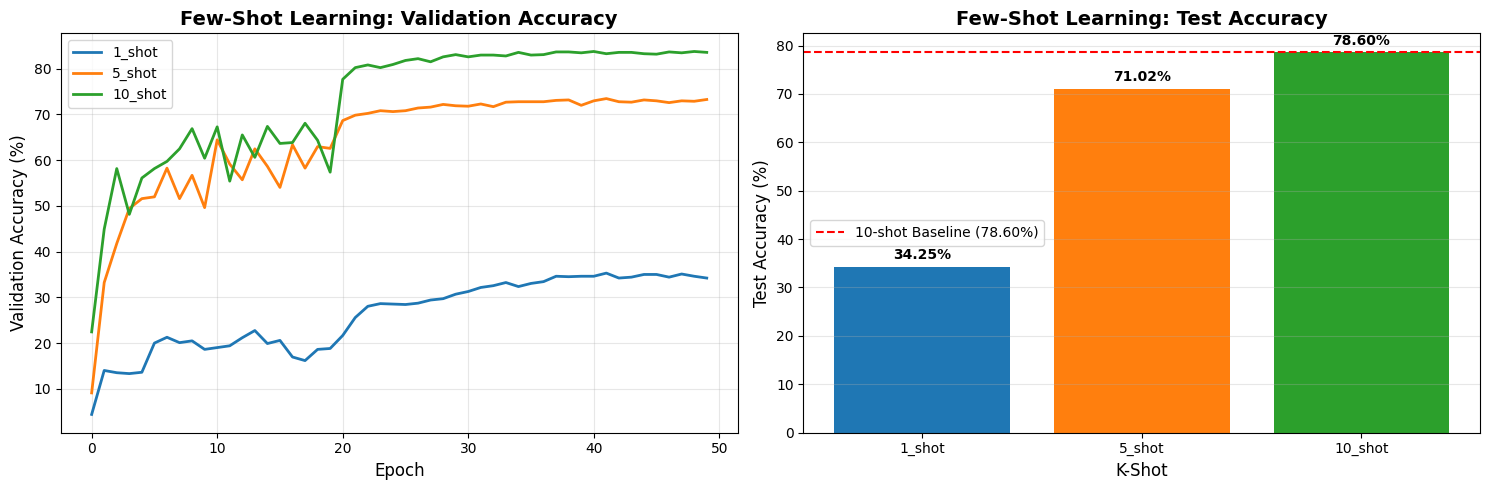

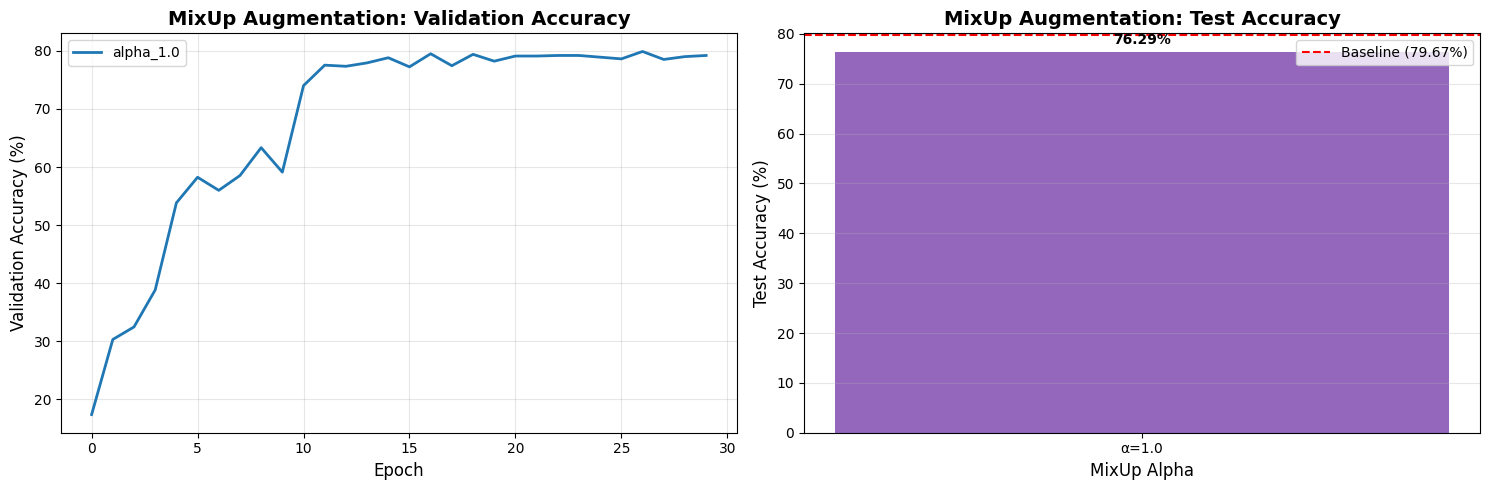

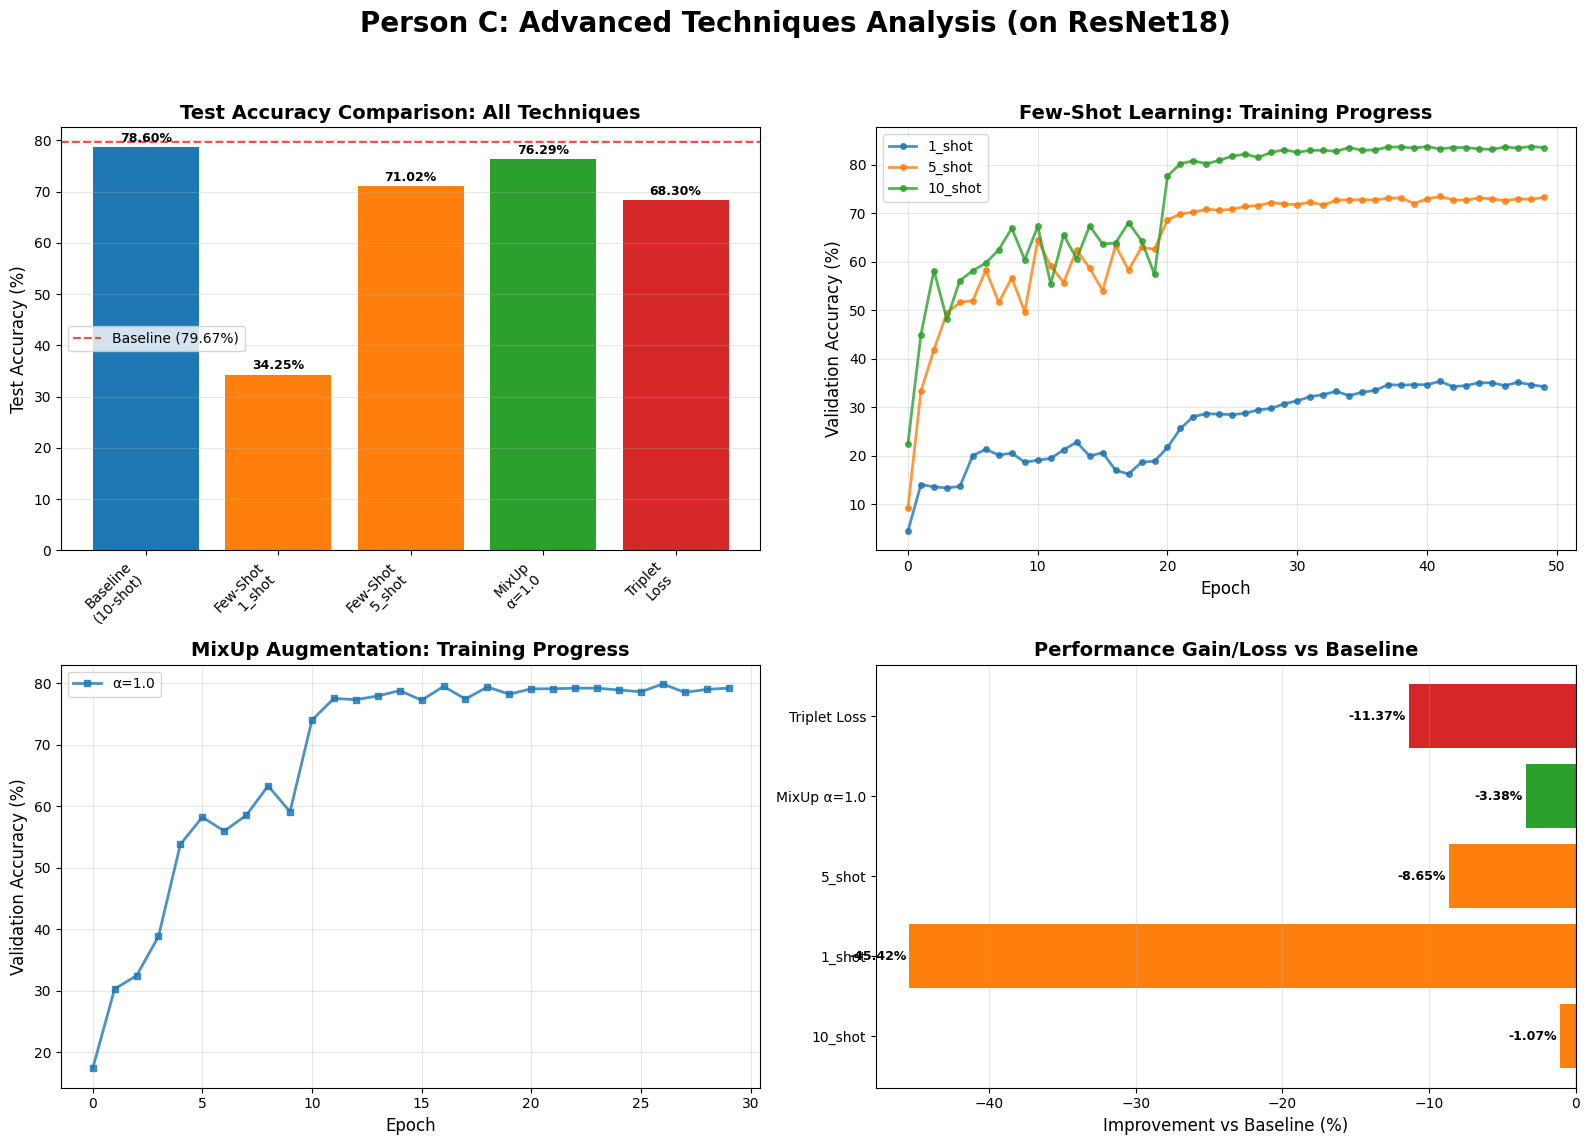


COMPREHENSIVE RESULTS COMPARISON

### Baseline (Person A) ###
ResNet18 (10-shot Training): 79.67%

### Best Architecture (Person B) ###
Best Model (ViT): 85.51% (For reference)

### Few-Shot Learning (Person C, ResNet18) ###
Method                         Val Acc         Test Acc        vs Baseline    
---------------------------------------------------------------------------
1_shot                         35.29           34.25           -45.42%
5_shot                         73.43           71.02           -8.65%
10_shot                        83.73           78.60           -1.07%

### MixUp Augmentation (Person C, ResNet18) ###
Method                         Val Acc         Test Acc        vs Baseline    
---------------------------------------------------------------------------
MixUp alpha_1.0              79.90           76.29           -3.38%

### Triplet Loss (Person C, ResNet18) ###
Method                         Val Acc         Test Acc        vs Baseline    
--------------

In [54]:
# ============================================
# MAIN EXECUTION
# ============================================

# Set to False for full run, True for a quick test
QUICK_TEST = False

# Load baseline results to pass to report
# (Assuming Person A's baseline is 79.67% and Person B's is 85.51%)
baseline_acc_a = 79.67
baseline_acc_b = 85.51

print("\n" + "="*80)
print("PERSON C - ADVANCED TECHNIQUES MODULE")
print("="*80)

# Run experiments
results = run_all_experiments(quick_test=QUICK_TEST)

# Generate visualizations
print("\nGenerating visualizations...")

if 'fewshot' in results and results['fewshot']:
    # Use the 10-shot result as the baseline for the plot
    baseline_10_shot_acc = results['fewshot'].get('10_shot', {}).get('test_acc', baseline_acc_a)
    plot_fewshot_comparison(results['fewshot'], baseline_acc=baseline_10_shot_acc)

if 'mixup' in results and results['mixup']:
    plot_mixup_comparison(results['mixup'], baseline_acc=baseline_acc_a)

plot_all_techniques_comparison(results, baseline_acc=baseline_acc_a)

# Generate comparison table
create_comparison_table(results, baseline_acc=baseline_acc_a, person_b_best_acc=baseline_acc_b)

# Generate detailed analysis report
generate_analysis_report(results, baseline_acc=baseline_acc_a)

print("\n" + "="*80)
print("PERSON C EXPERIMENTS COMPLETE!")
print("Results saved in: results/person_c/")
print("="*80)